# Evaluating the Performance of the Classifier - Imbalanced datasets

In this notebook we are going to explore the [Bosch Production Line Performance](https://www.kaggle.com/c/bosch-production-line-performance/data) dataset, which was part of the [Kaggle](https://www.kaggle.com) competition sponsored by Bosch in 2016. The data for this competition represents measurements of components as they move through Bosch's production lines. Each component has a unique Id. The goal is to predict which components will fail quality control (represented by a **Response** = 1).

The dataset contains an extremely large number of anonymized features. Features are named according to a convention that tells you the production line, the station on the line, and a feature number. E.g. L3_S36_F3939 is a feature measured on line 3, station 36, and is feature number 3939.

As it is a very large dataset, we are going to use a reduced training dataset. In 2016 the original dataset was one of the largest datasets (in terms of number of features) ever hosted on Kaggle. Besides that, this dataset is highly **imbalanced**. Given our time and computational resources restrictions, we selected the most promissing features (according to these [kernels](https://www.kaggle.com/c/bosch-production-line-performance/kernels)) and cleaned the dataset (mainly replacing the NaN values by the mean by using [this](http://scikit-learn.org/stable/modules/impute.html#impute) approach). We also removed the temporal dependencies in order to facilitate the illustratation of the concepts we want to discuss.

The original dataset is composed by 1,183,747 samples, distributed as:
 - 1,176,868 samples for Response 0
 - 6,879 samples for Response 1
 
We random sampled this dataset to a much smaller one, making the effort of matching the original distribution. The reduced dataset has the following distribution:
 - 19,700 samples for Response 0
 - 300 samples for Response 1
 
Note that the reduced dataset still **highy imbalanced**. In this notebook, we are going to show the effect of the evaluation performance metrics discussed in the previous notebook under this highly imbalanced dataset. We will implement ideas about how we can deal with such scenario in order to improve the generalisation of the classifier. For instance, it is clear that a simple accuracy won't give us reliable results (we could just pick the most frequent class and have similar accuracies).

In order to have a clean notebook, some functions are implemented in the file *utils.py* (e.g., plot_decision_boundary). We are not going to discuss the implementation aspects of these functions as it is not the scope, but you can to explore and read the content of the functions later on.

Summary:
 - [Data Pre-processing](#data_preprocessing)
 - [Building the Random Forest Classifier](#models)
 - [Quantifying the Quality of Predictions](#pred)
     - [Accuracy](#accuracy)
     - [Confusion Matrix](#confusion)
     - [Precision and Recall](#precision)
     - [F1-score](#f1score)
     - [Receiver Operating Characteristic (ROC) and Area Under the Curve (AUC)](#roc)
     - [K-fold Cross-Validation](#kfold)
     - [Discussion](#mat)
 - [Dealing with Imbalanced Dataset](#imbalanced)
  
__All the libraries used in this notebook are <font color='red'>Open Source</font>__.

## Data Pre-processing
<a id=data_preprocessing></a>

In [1]:
# Standard libraries
import numpy as np  # written in C, is faster and robust library for numerical and matrix operations
import pandas as pd # data manipulation library, it is widely used for data analysis and relies on numpy library.
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # plot nicely =)

from sklearn.model_selection import train_test_split #split arrays or matrices into random train and test subsets
from sklearn.preprocessing import StandardScaler #Standardize features by removing the mean and scaling to unit variance

# Auxiliar functions
from utils import *

# the following to lines will tell to the python kernel to always update the kernel for every utils.py
# modification, without the need of restarting the kernel.
%load_ext autoreload
%autoreload 2

# using the 'inline' backend, your matplotlib graphs will be included in your notebook, next to the code
%matplotlib inline

Reading the reduced version of the dataset. It is all prepared for you in "reduced_train.csv". 

In [2]:
# reading dataset
data = pd.read_csv("../data/reduced_train.csv", index_col=0, header=0)

data.head()

,L0_S0_F22,L0_S1_F28,L0_S5_F114,L1_S24_F1844,L1_S24_F1846,L2_S26_F3113,L3_S29_F3321,L3_S29_F3324,L3_S29_F3354,L3_S29_F3376,...,L3_S30_F3759,L3_S32_F3850,L3_S33_F3857,L3_S33_F3859,L3_S33_F3865,L3_S35_F3889,L3_S38_F3952,L3_S38_F3956,L3_S38_F3960,Response
707234,0.000286,-0.000166,0.000066,-0.353000,0.233000,-0.047000,-0.039000,-0.207000,0.125000,-0.104000,...,0.106000,0.000029,0.087000,-0.158000,-0.006000,0.000005,0.000289,-0.000274,-0.000011,0
305524,0.027000,-0.069000,0.000066,-0.000328,-0.000144,0.000322,-0.039000,0.012000,-0.099000,-0.002000,...,-0.127000,0.000029,-0.010000,0.204000,0.116000,0.000005,0.000289,-0.000274,-0.000011,0
1139731,-0.323000,-0.208000,0.000066,-0.000328,-0.000144,0.000322,-0.104000,0.056000,0.193000,-0.002000,...,-0.131000,0.000029,-0.031000,-0.171000,0.018000,0.000005,0.000289,-0.000274,-0.000011,0
702248,-0.110000,0.284000,0.160000,-0.000328,-0.000144,0.000322,-0.027000,0.019000,-0.200000,-0.060000,...,0.077000,0.000029,-0.003000,0.199000,-0.047000,0.034000,0.000289,-0.000274,-0.000011,0
161369,-0.285000,-0.007000,0.039000,-0.000328,-0.000144,0.000322,-0.000164,0.000102,-0.000059,-0.000091,...,0.000032,0.000029,-0.000043,0.000031,-0.000045,0.000005,0.000289,-0.000274,-0.000011,0


Analising the distribution of the classes (Response).

Response 0: 19700
Response 1: 300
Proportion: 65.67 : 1


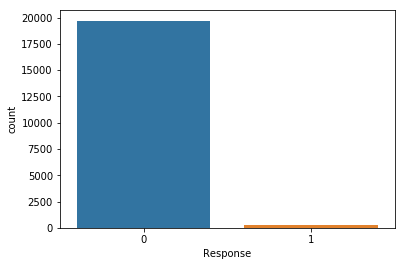

In [3]:
y = data.Response # set the variable 'y' to store the labels
list = ['Response']
data = data.drop(list,axis = 1 ) # removing the column Response from the dataframe
data.head()

# counting the number of unique labels in the dataset.
target_count = y.value_counts()
print('Response 0:', target_count[0])
print('Response 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

ax = sns.countplot(y, label="Count")

As you can see, this dataset is highly imbalanced!!! Generally, we will have much more data from one class (Reponse 0) and much less data from the other class (Response 1). There are some techniques to deal with such imbalanced dataset, we are going to discuss them further in this notebook.

In [6]:
# split data train 70% and test 30%. You can try other splits here.
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.3, 
                                                    random_state=42)

# normalising the data
scaler = StandardScaler()
scaler.fit(x_train) 

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
y_train = y_train.values # converting to numpy array
y_test = y_test.values # converting to numpy array

## Building the Random Forest Classifier
<a id=models></a>

In [8]:
from sklearn.ensemble import RandomForestClassifier # implements random decision forest.

clf_rf = RandomForestClassifier(n_estimators=10) #10 trees in the forest 
clr_rf = clf_rf.fit(x_train_scaled, y_train)

## Quantifying the Quality of Predictions
<a id=pred></a>

The performance assessment of the **classifiers** is extremely important in practice, as this provide insights of how the classifier performs with new data, in which me measure the **generalisation error**.

Summary:
 - [Accuracy](#accuracy)
 - [Confusion Matrix](#confusion)
 - [Precision and Recall](#precision)
 - [F1-score](#f1score)
 - [Receiver Operating Characteristic (ROC) and Area Under the Curve (AUC)](#roc)
 - [K-fold Cross-Validation](#kfold)
 - [Learning Curve](#learning)

### Accuracy
<a id=accuracy></a>

Computes the accuracy of the classifier by  using the following equation:

$$accuracy = \frac{1}{N}\sum_{i=0}^N{1*(\hat{y}==y)}$$
where $y$ is the true label, $\hat{y}$ the predicted label and $N$ is the number of samples.

In [9]:
from sklearn.metrics import accuracy_score

# we are using prediction computed previsously
prediction = clr_rf.predict(x_test_scaled)

accuracy_rf = accuracy_score(y_test, prediction)

print('Accuracy: ', accuracy_rf)

Accuracy:  0.9863333333333333


We just get 98.6% of **accuracy**. Let's use other tools to quantify the quality of predictions for our classifier and check if this accuracy is reliable.

### Confusion Matrix
<a id=confusion></a>

The confusion matrix is a tool/technique for summarising the performance of the classifier. We can have better insights about when the classifier is getting right and what are the types of errors it is making. It can be very useful for a further improvement of our models.

<img src="imgs/cm.png" alt="Drawing" style="width: 400px;"/>


In the image above, we have: 
 - **True Positive (TP):** correctly predicted event values.
 - **False Positive (FP):** incorrectly predicted event values.
 - **True Negative (TN):** correctly predicted no-event values.
 - **False Negative (FN):** incorrectly predicted no-event values.

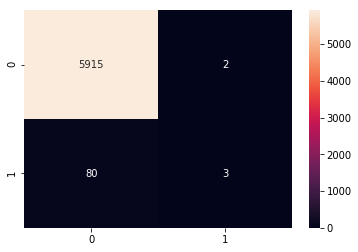

In [10]:
#  confusion_matrix: computes confusion matrix to evaluate the accuracy of a classification
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True,fmt="d")

**Question**: What is strange with this confustion matrix?

Tip: there is 19,700 samples for response 0 (True Positives) and 300 samples for response 1 (True Negatives). 

### Precision-Recall
<a id=precision></a>

The confusion matrix give us a lot of information, but sometimes we may need a better metric in order to evaluate the classifier accuracy. Precision and recall scores are two metrics naturally provided by confusion matrix evaluation.


Precision is given by the equation:

$$precision = \frac{TP}{TP + FP}$$
where $TP$ is the number of True Positives and $FP$ is the number of False Positives.


Recall is given by the equation:

$$recall  = \frac{TP}{TP + FN}$$
where $TP$ is the number of True Positives and $FN$ is the number of False Negatives.



In [11]:
# Libraries:
#   precision_score: computes precision score
#   recall_score: computes recall score
from sklearn.metrics import precision_score, recall_score

# we are using prediction computed previsously
precision_rf = precision_score(y_test, prediction)
recall_rf = recall_score(y_test, prediction)

print('Precision: ', precision_rf)
print('Recall: ', recall_rf)

Precision:  0.6
Recall:  0.03614457831325301


**Question** What? Why precision and recall scores are so different, and also different from accuracy score? Why recall score is so small?

### F1-score
<a id=f1score></a>

Also known as **F-Measure**, can be interpreted as a weighted average of the precision and recall. The formula for F1-score is:

$$f_1 = 2 * \frac{precision * recall}{precision+recall}$$

In [12]:
from sklearn.metrics import f1_score # computes the f1 score

# we are using prediction computed previsously
f1_score_rf = f1_score(y_test, prediction)
print('F1-score: ', f1_score_rf)

F1-score:  0.06818181818181818


This again confirms that the classifier is leading to a lot of misclassifications. In our case, our classifier can't be applied for quality control.

### Receiver Operating Characteristic (ROC) and Area Under the Curve (AUC)
<a id=roc></a>

#### Receiver Operating Characteristic (ROC) 
ROC curve plot the *true positive rate-TPR* (a.k.a. *recall score*) against the *false negative rate-FPR*. FPR is the ratio of negative instances that are incorrectly classifier as positive.


#### Area Under the Curve (AUC)

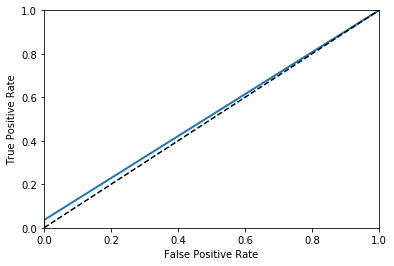

AUC:  0.5179032845935033


In [13]:
# Libraries:
#  roc_curve: computes the receiver operating characteristic curve
#  roc_auc_score: computes Area Under the Receiver Operating Characteristic Curve score
from sklearn.metrics import roc_curve, roc_auc_score

# computing and plotting the ROC curve
fpr, tpr, _ = roc_curve(y_test, prediction)

plot_roc_curve(fpr=fpr, tpr=tpr)

# computing the AUC (Area Under the Curve)
auc_rf = roc_auc_score(y_test, prediction)
print('AUC: ', auc_rf)

**Question** Could you interpret what means AUC equal 0.5? In this problem we have just two classes (Response 0 and Reponse 1), the probability to have a Response 0 is given by $P(Response = 0) = 0.5$ and to have a Response 1 is  $P(Response = 1) = 0.5$. This means that, if we do a random guess the response we can have 50% of accuracy. Having said that, is it worth to build a model with 50% of accuracy?

### K-fold Cross-Validation
<a id=kfold></a>

In [14]:
# We are using the library StratifiedKFold for this task.
#   The StratifiedKFold performs stratified sampling to produce folds that contain a representative ratio of each 
#   class. At each iteraction the code create a clone of the classifier, train that clone on the training 
#   folds, and makes prediction on the test fold. 
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

cv = StratifiedKFold(n_splits=5, random_state=42)

auc_scores = []
f1_scores = []
for train, test in cv.split(x_train_scaled, y_train):
    clone_clf = clone(clf_rf)
    
    # splitting the training set
    x_train_folds = x_train_scaled[train]
    y_train_folds = y_train[train]
    x_test_folds = x_train_scaled[test]
    y_test_folds = y_train[test]
    
    # building the classifier
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_folds)
    
    # computing the auc score
    auc_scores.append(roc_auc_score(y_test_folds, y_pred))
    
    # computing the f1-score
    f1_scores.append(f1_score(y_test_folds, y_pred))
    

fold = 1
print('Fold\tAUC\tF1-score')
for auc, f1 in zip(auc_scores, f1_scores):
    print('{}\t{:.3f}\t{:.3f}'.format(fold, auc, f1))
    fold += 1

print()
print('Mean AUC: {:.3f}'.format(np.array(auc_scores).mean()))
print('Mean F1-score: {:.3f}'.format(np.array(f1_scores).mean()))

Fold	AUC	F1-score
1	0.523	0.087
2	0.534	0.122
3	0.523	0.089
4	0.512	0.045
5	0.546	0.167

Mean AUC: 0.528
Mean F1-score: 0.102


Even by using K-fold cross-validation, we were not able to build a better classifier. 

### Metrics Discussion
<a id=mat></a>

In scenarios where we aim at detecting samples of a minority class (Response = 1 in our case), we are usually concerned to achieve a better recall than a better precision. You can imagine situations where it is usually more expensive to miss a negative sample (false positive) than to falsely classify a positive sample. Therefore, when comparing approaches to deal with imbalanced datasets, it is crucial to consider metrics beyond accuracy (as we saw above) such as recall and AUC. Other metrics, such as the Matthews Correlation Coefficient (MCC)](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient) can be compute as well, as this last one can deal with imbalanced dataset and will give more importance to negative samples, which is our case. 

The MCC equation is given by:

$$MCC = \frac{TP*TN - FP*FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$

The [Matthews Correlation Coefficient (MCC)](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient) is, in essence, a correlation coefficient value between -1 and +1:
 - MCC equals +1 represents a perfect prediction
 - MCC equals 0 an average random prediction
 - MCC equals -1 an inverse prediction. 
 
In scikit learn, you can compute this coefficient as follows:
```python
from sklearn.metrics import matthews_corrcoef #Implements the Matthews correlation coefficient

mcc_rf = matthews_corrcoef(y_test, prediction)
print('Matthews correlation coefficient is: ', mcc_rf)
```

Try the code above if you which.

## Dealing with Imbalanced Dataset
<a id=imbalanced></a>

### Cost-sensitive Learning

Generally, the misclassification are treated equally, which causes problems in imbalaced scenarios, as there is not a reward for identifying the minority class over the majority class. In *cost-sensitive learning* approach, in order to increase the true positive rate, the misclassification for the minority class are heavly penalised more than the missclassifications of the majority class. For very large dataset, this approach is costly computationally.

### Sampling

Sampling is a simple way to fix imbalanced datasets, the basic idea is to create or remove samples in order to balance them. Two main approaches can be used in order to balance the dataset:

 - Oversampling, which creates samples for the minority class. In practice, this techniques can lead to overfitting, since we are introducing duplicated samples.
 - Undersampling, which removes samples from the majority class. In practice, this can enp up by removing important samples that are more discriminative between the two classes.

The Figure below illustrates the basic idea behind sampling (click [here](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets) to see the reference).
<img src="imgs/resampling.png" alt="Drawing" style="width: 700px;"/>


Several powerful samples methods have been proposed in order to avoid the practical problems of oversampling or undersampling. In this notebook we are going to focus in an specific oversampling method known as [Synthetic Minority Over-sampling Technique (SMOTE)](https://jair.org/index.php/jair/article/view/10302). This method creates new samples of the minotiry class by forming convex combination of the neighboring samples.

<img src="imgs/smote.png" alt="Drawing" style="width: 400px;"/>

As can be seen in the figure, SMOTE effectively draws lines between minority smaples in the feature space, and samples along these lines. The key of this approach is that it creates new synthetic samples rather than duplicates existing samples, this allows datasets to be balanced without including too much overfitting. However, this does not prevent all overfitting, as these are still created from existing data points.

In order to apply the SMOTE approach we are going to use the Python library [imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/). It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

In [41]:
from imblearn.over_sampling import SMOTE # implements SMOTE

sampling = SMOTE()

Xs, ys = sampling.fit_sample(data, y) # create the new synthetic samples

Response == 0: 19700
Response == 1: 19700
Proportion: 1.0 : 1


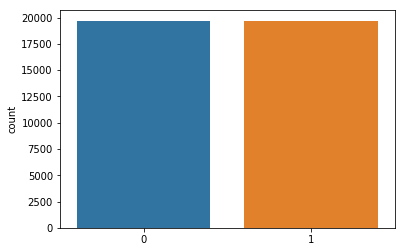

In [43]:
# Ploting the new class distributions
unique, counts = np.unique(ys, return_counts=True)

print('Response == {}:'.format(unique[0]), counts[0])
print('Response == {}:'.format(unique[1]), counts[1])
print('Proportion:', round(counts[0] / counts[1], 2), ': 1')

ax = sns.countplot(ys, label="Count")

In [47]:
# split data train 70% and test 30%. You can try other splits here.
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(Xs, ys, test_size=0.3, random_state=42)

# normalising the data
scaler = StandardScaler()
scaler.fit(x_train_new)

x_train_new = scaler.transform(x_train_new)
x_test_new = scaler.transform(x_test_new)

In [48]:
# Building the classifier
from sklearn.ensemble import RandomForestClassifier # implements random decision forest.

clf_rf_i = RandomForestClassifier(n_estimators=10) #10 trees in the forest 
clf_rf_i.fit(x_train_new, y_train_new)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

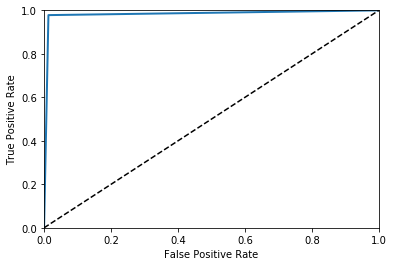

AUC:  0.9825651721043784


In [49]:
prediction = clf_rf_i.predict(x_test_new)

# computing and plotting the ROC curve
fpr, tpr, _ = roc_curve(y_test_new, prediction)

plot_roc_curve(fpr=fpr, tpr=tpr)

# computing the AUC (Area Under the Curve)
auc_rf_i = roc_auc_score(y_test_new, prediction)
print('AUC: ', auc_rf_i)

<module 'matplotlib.pyplot' from '/Users/mrmansour/anaconda3/envs/week06/lib/python3.6/site-packages/matplotlib/pyplot.py'>

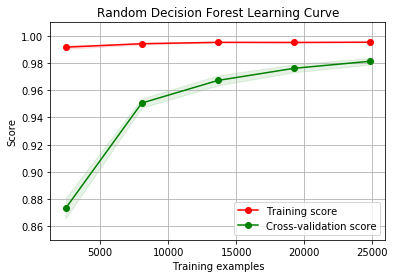

In [52]:
cv = StratifiedKFold(n_splits=10, random_state=42)

plot_learning_curve(clf_rf_i, title='Random Decision Forest Learning Curve', 
                    X=x_train_new, 
                    y=y_train_new, 
                    ylim=(0.85, 1.01), 
                    cv=cv, 
                    n_jobs=5)

In some cases it can let to overfitting. However, more powerful techniques were proposed in order to reduce it. For example, the technique [Adaptive Synthetic (ADASYN)](https://sci2s.ugr.es/keel/pdf/algorithm/congreso/2008-He-ieee.pdf), which is an improved version of SMOTE. This approach, after creating the new samples adds a random small values to the samples thus making them more realistic. In this sense, instead of all the samples being linearly correlated to the neighbors, they have a little more variance in them.

This technique is implemented in the library **imblearn**, and can be used as follows:

```python
from imblearn.over_sampling import ADASYN # implements SMOTE

sampling = ADASYN()

Xs, ys = sampling.fit_sample(data, y) # create the new synthetic samples
```

Try the code above and see if you can find some difference in the result.